In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
!pip install yfinance

In [3]:
import yfinance as yf

In [54]:
today = datetime.today()

In [55]:
days = timedelta(days=1000)

In [56]:
start = today-days

In [57]:
print('start:', start, '\t', 'end:', today)

start: 2019-10-29 01:56:21.654219 	 end: 2022-07-25 01:56:21.654219


In [58]:
stk = 'NKE'

In [59]:
stk = yf.download(stk, start, today)
df = stk[['Open', 'Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [60]:
df.tail()

,Open,Adj Close
Date,,
2022-07-18,106.190002,103.940002
2022-07-19,105.599998,109.190002
2022-07-20,109.220001,111.110001
2022-07-21,110.370003,111.620003
2022-07-22,111.930000,109.120003


In [61]:
df.shape

(688, 2)

In [62]:
df = df.drop('Open', axis=1)

In [63]:
df.shape

(688, 1)

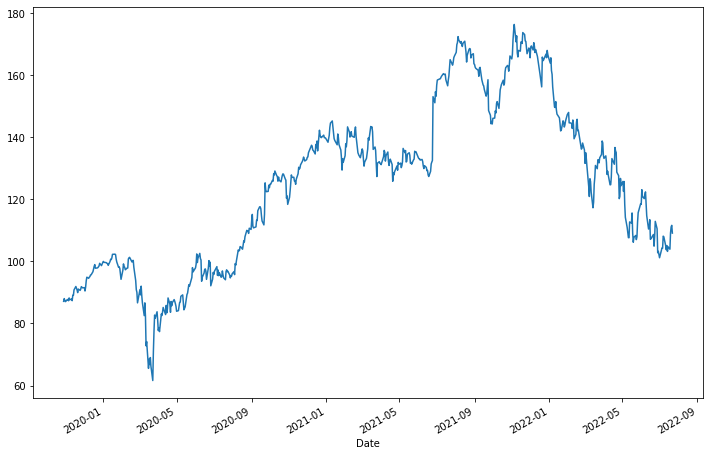

In [64]:
df['Adj Close'].plot(figsize=(12,8))

Train Test Split

In [100]:
test_size = 24

In [101]:
test_ind = len(df)- test_size # test index

In [102]:
train = df.iloc[:test_ind] # training set
test = df.iloc[test_ind:] # testing set is last 24 values

Scale Data

In [103]:
from sklearn.preprocessing import MinMaxScaler

In [104]:
scaler = MinMaxScaler()

In [105]:
scaler.fit(train)

MinMaxScaler()

In [106]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Time Series Generator

In [107]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [108]:
length = 24
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

Create the Model

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [110]:
n_features = 1

In [111]:
model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [112]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 75)                23100     
                                                                 
 dense_4 (Dense)             (None, 1)                 76        
                                                                 
Total params: 23,176
Trainable params: 23,176
Non-trainable params: 0
_________________________________________________________________


In [113]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=18, batch_size=1)

In [114]:
from tensorflow.keras.callbacks import EarlyStopping

In [115]:
early_stop = EarlyStopping(monitor='val_loss',patience=6)

In [116]:
model.fit_generator(generator,epochs=50,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


640/640 [==============================] - 8s 11ms/step - loss: 0.0170 - val_loss: 0.0020
Epoch 2/50
640/640 [==============================] - 7s 11ms/step - loss: 0.0028 - val_loss: 6.2892e-04
Epoch 3/50
640/640 [==============================] - 7s 11ms/step - loss: 0.0022 - val_loss: 6.8695e-04
Epoch 4/50
640/640 [==============================] - 7s 11ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/50
640/640 [==============================] - 7s 11ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/50
640/640 [==============================] - 7s 11ms/step - loss: 0.0013 - val_loss: 7.4988e-04
Epoch 7/50
640/640 [==============================] - 7s 11ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
640/640 [==============================] - 7s 11ms/step - loss: 9.8952e-04 - val_loss: 5.0734e-04
Epoch 9/50
640/640 [==============================] - 7s 11ms/step - loss: 8.8384e-04 - val_loss: 0.0023
Epoch 10/50
640/640 [==============================] - 7s 11ms/step - loss: 8.

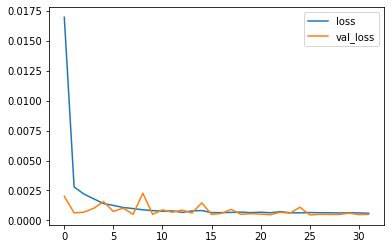

In [117]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Evaluate on Test Data

In [118]:
test_predictions = []
 
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [119]:
true_predictions = scaler.inverse_transform(test_predictions)

In [120]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [121]:
test

,Adj Close,Predictions
Date,,
2022-06-17,107.339996,106.969406
2022-06-21,108.680000,106.643904
2022-06-22,104.919998,106.463153
2022-06-23,108.000000,106.328483
2022-06-24,112.910004,106.248244
2022-06-27,110.500000,106.210280
2022-06-28,102.779999,106.202836
2022-06-29,103.250000,106.217491
2022-06-30,102.199997,106.248261


(0.0, 117.16032568627281)

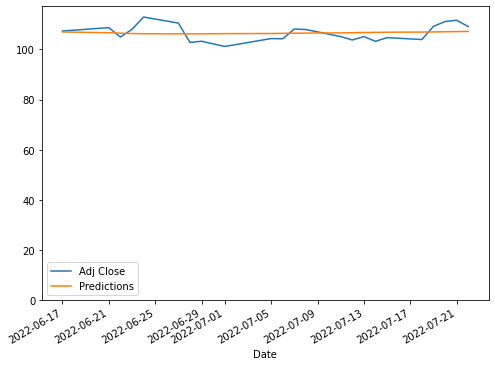

In [122]:
test.plot(figsize=(8,6))
plt.ylim(0, max(true_predictions)+10)

In [123]:
from sklearn import metrics

In [124]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(test['Adj Close'], test['Predictions'])))

RMSE: 3.1219568505658386


Forecast

In [125]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [126]:
length = 20 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [127]:
model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
 
 
# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


668/668 [==============================] - 8s 10ms/step - loss: 0.0140
Epoch 2/8
668/668 [==============================] - 6s 9ms/step - loss: 0.0017
Epoch 3/8
668/668 [==============================] - 6s 9ms/step - loss: 0.0015
Epoch 4/8
668/668 [==============================] - 6s 9ms/step - loss: 0.0014
Epoch 5/8
668/668 [==============================] - 6s 9ms/step - loss: 0.0013
Epoch 6/8
668/668 [==============================] - 6s 9ms/step - loss: 0.0012
Epoch 7/8
668/668 [==============================] - 6s 9ms/step - loss: 0.0012
Epoch 8/8
668/668 [==============================] - 6s 9ms/step - loss: 0.0011


In [128]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12
 
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [129]:
forecast = scaler.inverse_transform(forecast)

In [130]:
# set start date as next trading day
day = timedelta(days=1)
tomorrow = today + day
forecast_index = pd.date_range(start=tomorrow,periods=periods,freq='D')

In [131]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [132]:
forecast_df

,Forecast
2022-07-26 01:56:21.654219,110.264284
2022-07-27 01:56:21.654219,110.745258
2022-07-28 01:56:21.654219,111.201719
2022-07-29 01:56:21.654219,111.635699
2022-07-30 01:56:21.654219,112.061128
2022-07-31 01:56:21.654219,112.475533
2022-08-01 01:56:21.654219,112.874008
2022-08-02 01:56:21.654219,113.260447
2022-08-03 01:56:21.654219,113.635568
2022-08-04 01:56:21.654219,114.001967


(737361.080806183, 738373.080806183)

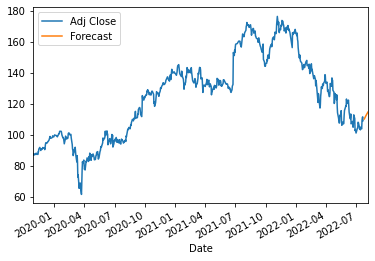

In [133]:
periods = timedelta(days=periods)
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim(start,today+periods)